N individuos : 

S susceptiveis

I infectados nao hospitalizados

H infectados hospitalizados 

R recuperados


- Taxa media de novos contagios $rI(t) = \beta(t) * (I(t) + H(t)) * S(t) / N$
em media 5% dos infectados sao $H \beta(t) = \beta(0) = 0.2592$

- 2 dias por mes são excepcionais;

- Nos dias excepcionais $\beta(t) = 3 * \beta(0)$

- Taxa media de recuperacao dos infectados nao hospitalizados $(I)$ eh $r_{RI}(t) =  \gamma_i I(t), 
( γ _i = 0.07143/dia)$ (duracao media da doenca ~= duas semanas)

- Taxa media de recuperacao dos infectados hospitalizados $(H)$ eh $r_{RH}(t) =  \gamma_i H(t)$, 
com $\gamma_i = 0.03571/dia$ (duracao media da doenca ~= quatro semanas)


_____________________________________________________________________________________
SIMULACAO 

N = $10^4$

$I(0)$ = rand(10, 20)

$H(0)$ = 0

$t$ ate nao haver mais pessoas hostpitalizadas por 3 dias seguidos

Queremos salvar as variaveis
- $X = max_t H(t)$
- O tempo T*, desde a primeira hospitalizacao ate o pico maximo de hospitalizados
- a fracao da populacao que teve a doenca uma vez acabada a epidemia. A fracao que esteve hospitalizada
- O tempo desde a primeira hospitalizacao ate a hospitalizacao numero 10, e ate a hopitalizacao 40 ($T_10$ e $T_40$))




O que descobrimos:


- $\beta$ é influenciado por $t$ da seguinte maneira:
A cada passagem de t, existe uma chance de $\frac{1}{15}$ de ser um dia especial, se for o caso, $\beta = 3 * \beta_0$
- Não esquecer q o número de recuperados não ode ser maior q o de novos infectados

In [1]:
import random
import numpy as np

In [2]:
def compare_sign(effective, received):
  for sign in received:
    if not effective.get(sign):
      continue
    if effective[sign][-1] != received[sign][-1]:
      return False
  return True

In [5]:
class SimulateEpidemic:

  def __init__(self, num_susceptible, num_infected = 0, num_hospitalized = 0, recovered = 0):   # initializing lists to hold acumulate values
      self.susceptible, self.infected, self.hospitalized, self.recovered = ([num_susceptible],
                                                                            [num_infected],
                                                                            [num_hospitalized], 
                                                                            [recovered])
      self.population_size = num_susceptible + num_infected + num_hospitalized + recovered

  pandemia_duration = 0
  curr_time = 1
  beta_zero = 0.2592            # cte to calculate infected rate
  avg_hospitalized = 0.05       # % to calculate number of infected  hospitalized
  days_high_prop = []

  @property
  def keys(self):
    return {"susceptible": self.susceptible, "infected": self.infected,
            "hospitalized": self.hospitalized, "recovered": self.recovered}

  @property
  def beta(self):               # 2 days in a month the cte multiplies by 3
    if random.random() <= 1/15:
      self.days_high_prop.append(self.curr_time)
      return self.beta_zero * 3
    else:
      return self.beta_zero

  @property
  def last_time(self):
    return self.curr_time - 1

  def last(self, variable):
    return variable[self.last_time]

  def update(self, variable, increment, is_new=True):
    new = self.last(variable) + increment
    if is_new:
      variable.append(new)
    else:
      variable[self.curr_time] += increment
      if variable[self.curr_time] < 0:
        variable[self.curr_time] = 0

  def step(self,recoveries, contagions):
    self.update(self.recovered, sum(recoveries))
    self.update(self.susceptible, -sum(new_contagions))

    self.update(self.hospitalized, new_contagions[0])
    self.update(self.hospitalized, -recoveries[0], False)

    self.update(self.infected, new_contagions[1])
    self.update(self.infected, -recoveries[1], False)

  def run(self, t, stop_sign=None, is_random=True): # is_random = True take a random value from poison distribution

    min_count = False
    distribution_func = (np.random.poisson if is_random else int)

    while (t > 0 or stop_sign["day_counter"] > 0) or not min_count :

      new_contagions_rate = self.new_contagions_rate_calculator()
      new_contagions = list(map(distribution_func,
                           [new_contagions_rate * self.avg_hospitalized, new_contagions_rate * (1 - self.avg_hospitalized)]))

      recoveries = list(map(distribution_func,
                       [self.avg_recovery(is_hospitalized=True), self.avg_recovery()]))

      #step(recoveries, new_contagions)
      self.update(self.recovered, sum(recoveries))
      self.update(self.susceptible, -sum(new_contagions))

      self.update(self.hospitalized, new_contagions[0])
      self.update(self.hospitalized, -recoveries[0], False)

      self.update(self.infected, new_contagions[1])
      self.update(self.infected, -recoveries[1], False)

      stop_sign["day_counter"] = (stop_sign["day_counter"] - 1 if compare_sign(self.keys, stop_sign) else stop_sign["days_without_hosp"])
      if new_contagions[0] != 0:
        min_count = True

      self.curr_time += 1
      t -= 1

      if(stop_sign["day_counter"] == 0):
        end_of_pandemia = self.curr_time
        self.pandemia_duration = self.curr_time

    #print(end_of_pandemia)

  def avg_recovery(self, is_hospitalized=False):
    if is_hospitalized:
      return 0.03751 * self.last(self.hospitalized)
    else:
      return 0.07143 * self.last(self.infected)

  def new_contagions_rate_calculator(self):
    return self.beta * (self.last(self.infected) + self.last(self.hospitalized)) * self.last(self.susceptible) / self.population_size

In [6]:
num_susceptible = 1e4
num_infected = random.randint(10, 20) # calculate infected

stop_signal = {"hospitalized": [0], "days_without_hosp": 3, "day_counter": 3}

simulation = SimulateEpidemic(num_susceptible, num_infected) # (num_population, num_infected_initial
simulation.run(0, stop_signal)

hospitalized_peak = max(simulation.hospitalized)
peak_index = simulation.hospitalized.index(hospitalized_peak)
hospitalized_first = np.nonzero(simulation.hospitalized)[0][0]

print(f"o maximo de hospitalizados é: {hospitalized_peak}")
print(f"o pico de hospitalizados foi no dia: {peak_index}")
print(f"T* = {peak_index - hospitalized_first}")
print("hospitalizados[dt=10] = {}, hospitalizados[dt=40] = {}".format(
    simulation.hospitalized[hospitalized_first + 10], 
    simulation.hospitalized[hospitalized_first + 40]))


o maximo de hospitalizados é: 296
o pico de hospitalizados foi no dia: 38
T* = 37
hospitalizados[dt=10] = 7, hospitalizados[dt=40] = 287


In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame.from_dict(simulation.keys)

In [9]:
df

,susceptible,infected,hospitalized,recovered
0,10000.0,18,0,0
1,9995.0,20,1,2
2,9988.0,26,1,3
3,9981.0,32,1,4
4,9971.0,37,3,7
...,...,...,...,...
208,130.0,0,1,9887
209,130.0,0,1,9887
210,130.0,0,0,9888
211,130.0,0,0,9888


In [10]:
sum(df.iloc[0]) == sum(df.iloc[-1])

True

# Matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

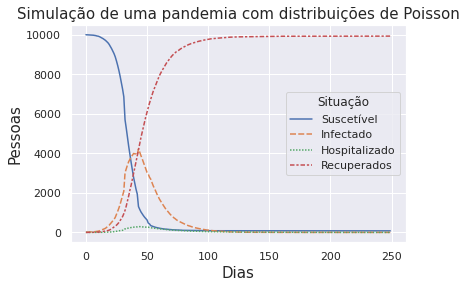

In [ ]:
graph = sns.lineplot(data=df)
graph.axes.set_title("Simulação de uma pandemia com distribuições de Poisson", fontsize=15)
graph.set_xlabel("Dias", fontsize=15)
#graph.set(yscale='log')
graph.set_ylabel("Pessoas", fontsize=15)
graph.legend(title='Situação', labels=['Suscetível', 'Infectado', "Hospitalizado", "Recuperados"])

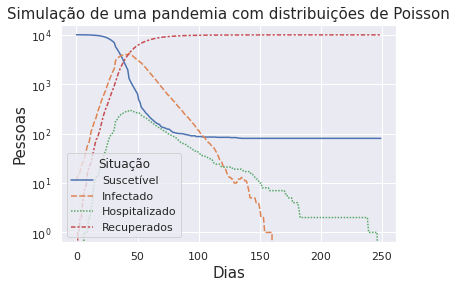

In [ ]:
graph = sns.lineplot(data=df)

graph.axes.set_title("Simulação de uma pandemia com distribuições de Poisson", fontsize=15)
graph.set_xlabel("Dias", fontsize=15)
graph.set(yscale='log')
graph.set_ylabel("Pessoas", fontsize=15)
# graph.refline(x = end_of_pandemia, color = "black") aaaa eu quero botar uma linha onde acaba a pandemia
graph.legend(title='Situação', labels=['Suscetível', 'Infectado', "Hospitalizado", "Recuperados"])

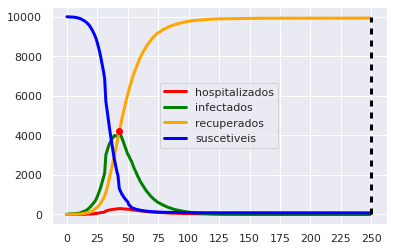

In [ ]:
plt.plot(np.arange(0,df.shape[0]),df['hospitalized'],color='red', lw=3)
plt.plot(np.arange(0,df.shape[0]),df['infected'], color='green', lw=3)
plt.plot(np.arange(0,df.shape[0]),df['recovered'], color='orange', lw=3)
plt.plot(np.arange(0,df.shape[0]),df['susceptible'],color='blue', lw=3)
plt.plot([df.shape[0],df.shape[0]], [0, 10000], 'k-',color='black', lw=3,dashes=[2, 2])
xtiques = list(np.arange(0,df.shape[0],25))
xtiques.append(df.shape[0])
plt.xticks(xtiques)

plt.plot([df['infected'].idxmax()],[df['infected'].max()],'ro',color='red')
plt.rcParams["figure.figsize"] = (15, 10)
plt.legend(['hospitalizados','infectados','recuperados','suscetiveis'],loc='best') # colocar legenda

# colocar pico de infectados com um dot
plt.show()

SystemError: ignored

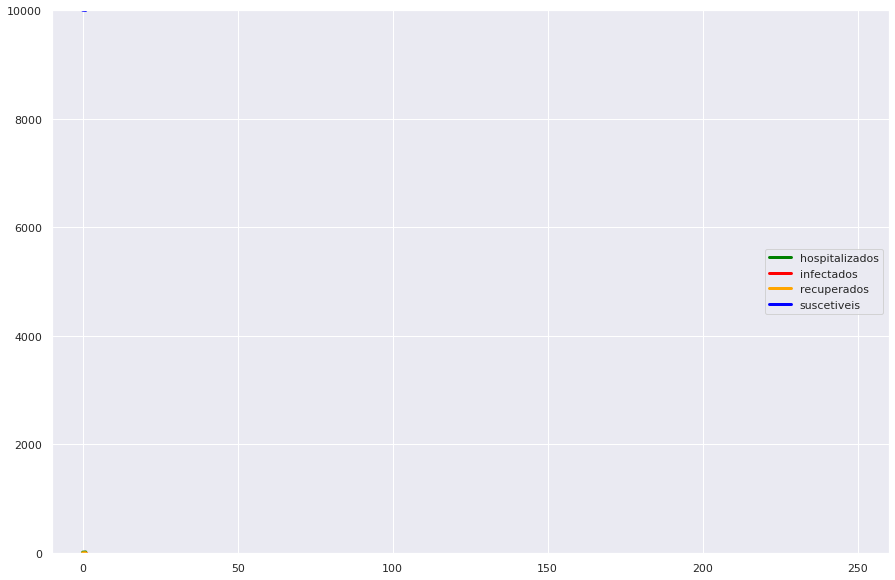

In [ ]:
filenames = []
x = list(df['infected'])
y = list(df['hospitalized'])
z = list(df['recovered'])
w = list(df['susceptible'])
for i in y:
    # plot the line chart
    plt.plot(x[:i],color='green', lw=3)
    plt.plot(y[:i],color='red', lw=3)
    plt.plot(z[:i],color='orange', lw=3)
    plt.plot(w[:i],color='blue', lw=3)

    plt.ylim(-10,10010)
    plt.xlim(-10,df.shape[0]+10)
    plt.legend(['hospitalizados','infectados','recuperados','suscetiveis'],loc='center right') # colocar legenda

    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [ ]:
# * propostas de analise
# - gerar vários gráficos analisando a duração da pandemia
# - fazer uma linha no gráfico indicando que acabou
# - talvez gerar os gráficos usando matplot ?
# - mudar o passo do tempo, 3 dias ? 7 dias ? é uma das questoes do pdf
# A distribuição ̧de probabilidade de T∗  ́e de bastante interesse. Qual seria o valor de t tal que Prob(T∗ < t) = 0.05?
# • Como variam os resultados do modelo quando  ́e variada a frequência dos eventos de aglomeração para 1/mês
# ou 3/mês? Como variam se a taxa de internacão n  ̃ao  ́e 5% (por exemplo, se fosse 1%)?
# • Os resultados dos modelos  são razoavelmente independentes do passo de tempo δt utilizado? Deveriam?
# •  ́E possível utilizar T10 e T40 para estimar em que momento acontece o pico de hospitalizações?


In [ ]:
plt.style.use("seaborn")
!pip install gif
import gif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4818 sha256=418ec69811cc22560e61430cf62bf889442c72fbf109fe2e5d2195de0abb002a
  Stored in directory: /root/.cache/pip/wheels/21/63/09/b1e3c512d244da0a7c1d9565f09592612d04b79ccbb95146ae
Successfully built gif


In [ ]:
@gif.frame
def helper_plot_1(df, i):
    df = df.copy()
    df.iloc[i:] = np.nan
    ax = df.plot(title="Gif", legend=False, style="o--")
    ax.set_xlabel("Dias")
    ax.set_ylabel("Pessoas")

KeyboardInterrupt: ignored

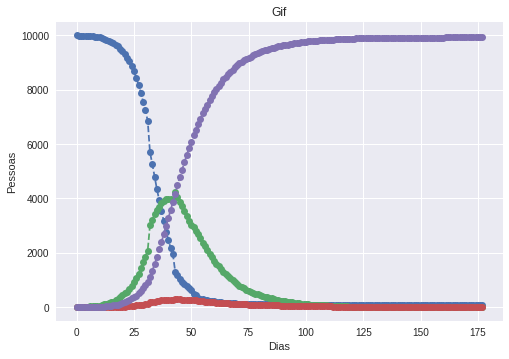

In [ ]:
frames = []
for i in range(1, len(df)):
    frames.append(helper_plot_1(df, i))